# Data Import - A first look over data

In [1]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.cluster import DBSCAN
import gc  # Import garbage collector interface

from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
dataset_path = '/kaggle/input/sncb-remote-diagnostics-in-fleet-maintenance/ar41_for_ulb.csv'

# Check if the file exists before trying to read it
if os.path.exists(dataset_path):
    data = pd.read_csv(dataset_path, delimiter=';')

    # Display the basic information and the first few rows of the dataframe
    data_info = data.info()
    data_head = data.head()

    # If you want to print the information to the console
    print(data_info)
    print(data_head)
else:
    print(f"The file {dataset_path} does not exist.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17679273 entries, 0 to 17679272
Data columns (total 15 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Unnamed: 0          int64  
 1   mapped_veh_id       float64
 2   timestamps_UTC      object 
 3   lat                 float64
 4   lon                 float64
 5   RS_E_InAirTemp_PC1  float64
 6   RS_E_InAirTemp_PC2  float64
 7   RS_E_OilPress_PC1   float64
 8   RS_E_OilPress_PC2   float64
 9   RS_E_RPM_PC1        float64
 10  RS_E_RPM_PC2        float64
 11  RS_E_WatTemp_PC1    float64
 12  RS_E_WatTemp_PC2    float64
 13  RS_T_OilTemp_PC1    float64
 14  RS_T_OilTemp_PC2    float64
dtypes: float64(13), int64(1), object(1)
memory usage: 2.0+ GB
None
   Unnamed: 0  mapped_veh_id       timestamps_UTC        lat       lon  \
0           0          181.0  2023-08-01 03:44:12  50.769818  3.872114   
1           1          143.0  2023-08-01 06:36:29  51.039993  3.693429   
2           2          183.0  2023

In [3]:
unique_train_id = data.mapped_veh_id.nunique()
print(f"number of unique_train_id: {unique_train_id}")

number of unique_train_id: 92


# Remove Column Unnamed: 0

In [4]:
data.drop(['Unnamed: 0'], axis=1, inplace = True)
data.shape

(17679273, 14)

# Interpolate 0 Place Holder

first let's check some 0 values in our data set

In [5]:
# change pd settings to show 50 rows
pd.set_option('display.max_rows', 50)

# change timestamps_UTC to date type
data['timestamps_UTC'] = pd.to_datetime(data['timestamps_UTC'])

# set time range
start_time = '2023-01-03 08:00:00'
end_time = '2023-01-03 14:00:00'

# filter time range
data[(data['timestamps_UTC'] >= start_time) & (data['timestamps_UTC'] <= end_time)].sort_values('timestamps_UTC')

,mapped_veh_id,timestamps_UTC,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2
15016592,114.0,2023-01-03 11:27:13,51.190767,5.114695,10.0,22.0,227.0,231.0,789.0,798.0,79.0,78.0,72.0,75.0
11039504,114.0,2023-01-03 13:12:15,51.192356,5.125106,15.0,25.0,403.0,382.0,1689.0,1723.0,80.0,80.0,77.0,79.0
13852976,137.0,2023-01-03 13:44:26,50.467882,4.840851,26.0,26.0,293.0,238.0,968.0,859.0,78.0,77.0,76.0,74.0
17411672,137.0,2023-01-03 13:45:32,50.467997,4.840934,25.0,26.0,238.0,210.0,798.0,798.0,78.0,77.0,76.0,76.0
6146137,137.0,2023-01-03 13:45:35,50.468380,4.840911,25.0,26.0,238.0,210.0,800.0,795.0,78.0,77.0,76.0,76.0
3527790,137.0,2023-01-03 13:46:31,50.468042,4.840836,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,77.0,74.0
17390282,137.0,2023-01-03 13:46:36,50.468447,4.840933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,77.0,75.0
17386049,137.0,2023-01-03 13:47:32,50.468038,4.840891,35.0,35.0,3.0,13.0,0.0,0.0,78.0,76.0,77.0,73.0
12089857,137.0,2023-01-03 13:47:36,50.468476,4.840945,35.0,35.0,3.0,13.0,0.0,0.0,78.0,76.0,77.0,73.0
17386050,137.0,2023-01-03 13:48:32,50.468092,4.840972,40.0,41.0,3.0,13.0,0.0,0.0,77.0,76.0,76.0,74.0


we can find that the distribution of 0 value is uncontinues mostly and just occupied a small part of data, so we can make use of linear interpolate to change those data, the 0 values here are more likely to be a place holder, every time the senser read errors or data lost, it put one place holder here

In [6]:
# Replace 0 with NaN in the 'RS_E_OilPress_PC2' column
data.replace(0, np.nan, inplace=True)

# Convert 'timestamps_UTC' to datetime, if not already done
data['timestamps_UTC'] = pd.to_datetime(data['timestamps_UTC'])

# Set 'timestamps_UTC' as the index
data.set_index('timestamps_UTC', inplace=True)

# Check for NaN values in the index
if data.index.hasnans:
    raise ValueError("The index contains NaNs, which cannot be present for time interpolation.")

# Interpolate only the NaN values in the 'RS_E_OilPress_PC2' column
data.interpolate(method='time', inplace=True)

and let's check the data again:

In [7]:
# get the column timestamps_UTC from index
data = data.reset_index()

In [8]:
# change pd settings to show 50 rows
pd.set_option('display.max_rows', 50)

# change timestamps_UTC to date type
data['timestamps_UTC'] = pd.to_datetime(data['timestamps_UTC'])

# set time range
start_time = '2023-01-03 13:00:00'
end_time = '2023-01-03 14:00:00'

# filter time range
data[(data['timestamps_UTC'] >= start_time) & (data['timestamps_UTC'] <= end_time)].sort_values('timestamps_UTC')

,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2
11039504,2023-01-03 13:12:15,114.0,51.192356,5.125106,15.000000,25.000000,403.000000,382.000000,1689.000000,1723.000000,80.0,80.000000,77.0,79.0
13852976,2023-01-03 13:44:26,137.0,50.467882,4.840851,26.000000,26.000000,293.000000,238.000000,968.000000,859.000000,78.0,77.000000,76.0,74.0
17411672,2023-01-03 13:45:32,137.0,50.467997,4.840934,25.000000,26.000000,238.000000,210.000000,798.000000,798.000000,78.0,77.000000,76.0,76.0
6146137,2023-01-03 13:45:35,137.0,50.468380,4.840911,25.000000,26.000000,238.000000,210.000000,800.000000,795.000000,78.0,77.000000,76.0,76.0
3527790,2023-01-03 13:46:31,137.0,50.468042,4.840836,29.786325,30.307692,125.521368,115.709402,802.346606,798.079257,78.0,76.521368,77.0,74.0
17390282,2023-01-03 13:46:36,137.0,50.468447,4.840933,30.213675,30.692308,115.478632,107.290598,802.556124,798.354190,78.0,76.478632,77.0,75.0
17386049,2023-01-03 13:47:32,137.0,50.468038,4.840891,35.000000,35.000000,3.000000,13.000000,804.902730,801.433447,78.0,76.000000,77.0,73.0
12089857,2023-01-03 13:47:36,137.0,50.468476,4.840945,35.000000,35.000000,3.000000,13.000000,805.070345,801.653394,78.0,76.000000,77.0,73.0
17386050,2023-01-03 13:48:32,137.0,50.468092,4.840972,40.000000,41.000000,3.000000,13.000000,807.416951,804.732651,77.0,76.000000,76.0,74.0
9365580,2023-01-03 13:48:36,137.0,50.468452,4.840933,40.000000,41.000000,3.000000,13.000000,807.584566,804.952598,77.0,76.000000,76.0,74.0


# Distribution of unique_train_id

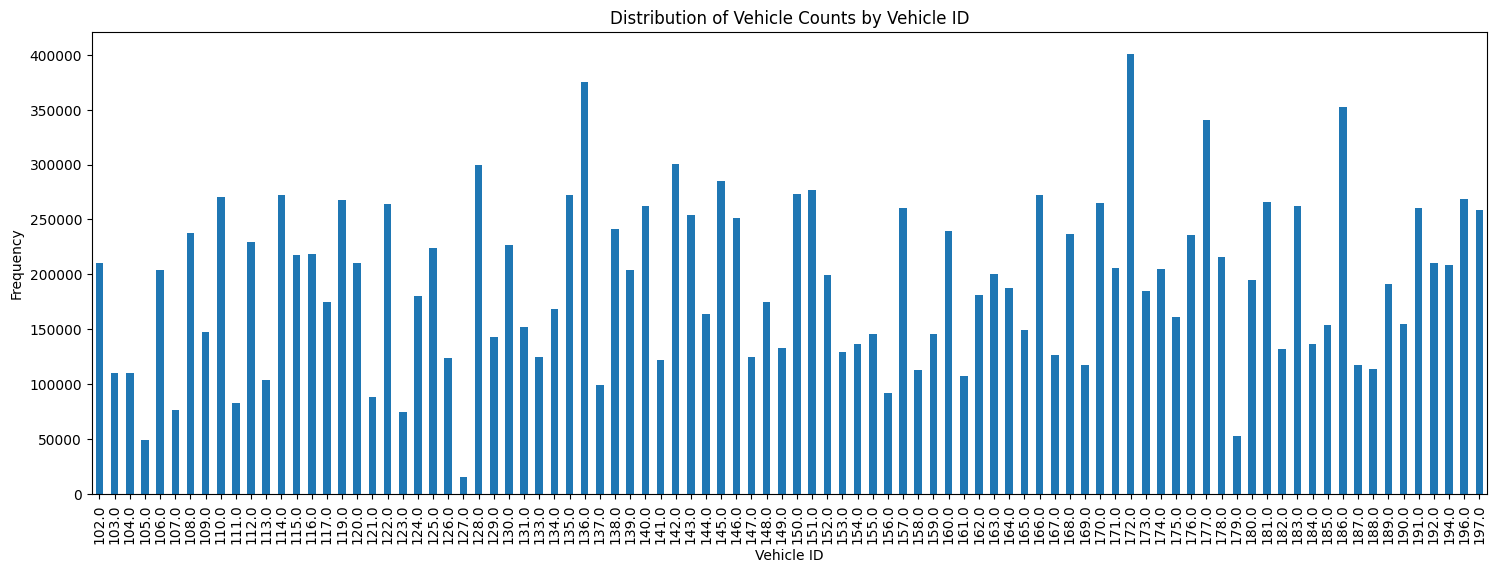

In [9]:
# First, group by 'mapped_veh_id' and count the occurrences
vehicle_counts = data.groupby('mapped_veh_id').size()

# Now, plot the bar chart
vehicle_counts.plot(kind='bar', figsize=(18, 6))

plt.title("Distribution of Vehicle Counts by Vehicle ID")
plt.xlabel("Vehicle ID")
plt.ylabel("Frequency")
plt.show()

# Distribution of RS_E_InAirTemp_PC1 and RS_E_InAirTemp_PC2

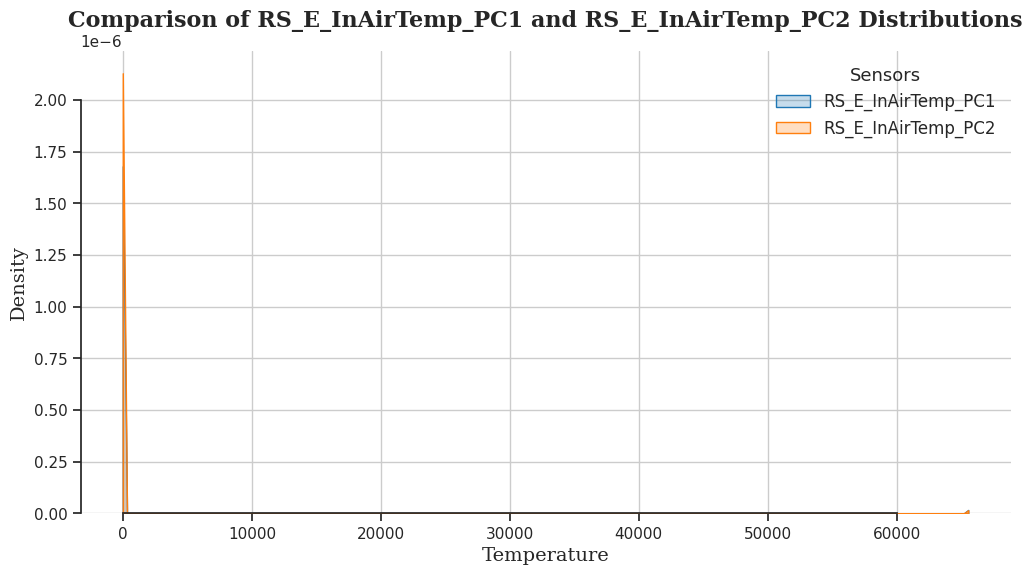

In [10]:
# Setting the overall aesthetics for the plot to have an academic look
sns.set_theme(style='ticks', palette='muted')

# Initialize the matplotlib figure
plt.figure(figsize=(12, 6))

# Plotting the Kernel Density Estimate (KDE) plot for RS_E_InAirTemp_PC1
sns.kdeplot(data['RS_E_InAirTemp_PC1'], fill=True, color="#1f77b4", label='RS_E_InAirTemp_PC1', bw_adjust=0.5)

# Plotting the KDE plot for RS_E_InAirTemp_PC2
sns.kdeplot(data['RS_E_InAirTemp_PC2'], fill=True, color="#ff7f0e", label='RS_E_InAirTemp_PC2', bw_adjust=0.5)

# Adding titles and labels with a formal font type
plt.title('Comparison of RS_E_InAirTemp_PC1 and RS_E_InAirTemp_PC2 Distributions', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Temperature', fontsize=14, family='serif')
plt.ylabel('Density', fontsize=14, family='serif')

# Adding gridlines and removing the top and right axis lines for a cleaner look
sns.despine(trim=True)
plt.grid(True)

# Adjusting the legend to be more formal
plt.legend(title='Sensors', title_fontsize='13', fontsize='12', frameon=False)

# Show the plot with the improved academic aesthetics
plt.show()


it seems there exists a very huge values that make this graph hard to tell

In [11]:
# Display the basic statistics for 'RS_E_InAirTemp_PC1' and 'RS_E_InAirTemp_PC2' to identify outliers
stats_pc1 = data['RS_E_InAirTemp_PC1'].describe()
stats_pc2 = data['RS_E_InAirTemp_PC2'].describe()

(stats_pc1, stats_pc2)

(count    1.767927e+07
 mean     3.230556e+01
 std      3.355557e+02
 min      5.813953e-02
 25%      2.200000e+01
 50%      3.200000e+01
 75%      4.000000e+01
 max      6.553500e+04
 Name: RS_E_InAirTemp_PC1, dtype: float64,
 count    1.767927e+07
 mean     3.262238e+01
 std      3.536705e+02
 min      3.333333e-01
 25%      2.200000e+01
 50%      3.300000e+01
 75%      3.900000e+01
 max      6.553500e+04
 Name: RS_E_InAirTemp_PC2, dtype: float64)

In [12]:
data[data['RS_E_InAirTemp_PC1'] > 1000].sort_values('timestamps_UTC').head()

,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2
7046724,2023-01-28 23:09:24,197.0,50.093630,4.529261,65533.0,52.0,610.0,348.0,799.0,452.5,3.0,3.0,1.0,4.0
15011888,2023-01-28 23:09:33,171.0,50.094173,4.528174,65535.0,65534.0,638.0,610.0,801.0,802.0,3.0,5.0,1.0,6.0
11906160,2023-01-28 23:09:37,171.0,50.093919,4.528709,65535.0,65534.0,617.0,610.0,798.0,800.0,3.0,5.0,1.0,6.0
15011889,2023-01-28 23:09:43,131.0,50.093910,4.528723,65535.0,65535.0,655.0,690.0,801.0,801.0,4.0,6.0,1.0,4.0
12881469,2023-01-28 23:10:14,197.0,50.093621,4.529263,65533.0,1.0,638.0,10.0,802.0,796.0,6.0,3.0,63.0,4.0


In [13]:
data[data['RS_E_InAirTemp_PC2'] > 1000].sort_values('timestamps_UTC').head()

,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2
2718274,2023-01-24 00:37:18,125.0,50.936568,5.306207,45.0,65519.0,3.0,690.0,803.0,663.0,65.0,-17.0,50.0,67.0
3419052,2023-01-25 14:14:41,156.0,51.014321,3.779286,2.0,65535.0,593.0,579.0,802.0,797.0,19.0,15.0,16.0,11.0
13874968,2023-01-25 14:14:54,156.0,51.014146,3.779875,2.0,65535.0,579.0,593.0,796.0,802.0,20.0,15.0,14.0,11.0
5670468,2023-01-25 14:15:55,156.0,51.014145,3.779855,2.0,65535.0,572.0,589.0,797.0,804.0,23.0,17.0,15.0,12.0
396913,2023-01-25 15:16:47,156.0,51.023516,3.758755,11.0,65535.0,434.0,472.0,879.0,872.0,52.0,48.0,52.0,47.0


the very huge temperature is not possible in the real world, and it coincidently to be the value of $2^16$ - 1, which is the maximum value for an unsigned 16-bit integer. And the other normal temperature in the near time is about 1 or 2 which is near to 0, so it is reasonable the temperature below 0 here, so we can solve this problem by make those data right 

In [14]:
# Minus 65536 to those abnormal data to make it right
data.loc[data['RS_E_InAirTemp_PC1'] > 65000, 'RS_E_InAirTemp_PC1'] -= 65536
data.loc[data['RS_E_InAirTemp_PC2'] > 65000, 'RS_E_InAirTemp_PC2'] -= 65536

In [15]:
# From the provided screenshot, it seems the user attempted to subtract 65536 from the outlier values directly in the condition statement.
# The correction should be applied to the dataframe itself. Let's apply the correction properly.

# Correcting the abnormal values by subtracting 65536 directly in the dataframe
data.loc[data['RS_E_InAirTemp_PC1'] > 65000, 'RS_E_InAirTemp_PC1'] -= 65536
data.loc[data['RS_E_InAirTemp_PC2'] > 65000, 'RS_E_InAirTemp_PC2'] -= 65536

# Let's check if the data has been updated by looking at the maximum values now
max_value_pc1_updated = data['RS_E_InAirTemp_PC1'].max()
max_value_pc2_updated = data['RS_E_InAirTemp_PC2'].max()

max_value_pc1_updated, max_value_pc2_updated

(52434.600000000006, 43694.33333333333)

but there are still some temperature larger than 30000 degree, let's figure out the reason behind this:

In [16]:
data.loc[data['RS_E_InAirTemp_PC1'] > 30000]

,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2
404130,2023-01-29 03:12:43,142.0,51.190537,5.112477,43691.000000,15.00,207.0,235.666667,804.0,796.0,78.0,19.0,76.0,17.0
1227635,2023-02-28 03:29:56,196.0,50.093810,4.528874,32767.500000,7.00,453.0,299.500000,799.0,797.5,36.0,61.0,35.5,60.5
2808943,2023-03-19 10:12:18,162.0,51.013141,3.781080,32759.500000,23.00,310.0,3.000000,1327.0,1331.0,29.0,22.0,58.0,20.5
4387156,2023-01-29 06:06:44,107.0,50.094944,4.526650,32773.000000,8.00,282.0,269.000000,802.0,800.0,79.0,33.0,77.0,66.0
4468288,2023-06-15 13:34:23,151.0,51.013158,3.780460,32759.500000,28.50,189.0,3.000000,811.0,1690.0,-8.5,27.0,16.5,27.5
4780282,2023-02-26 06:27:30,152.0,50.095487,4.525251,52434.600000,30.60,531.0,586.000000,803.0,804.0,18.0,17.0,6.0,5.0
4908458,2023-01-29 06:15:50,103.0,50.094405,4.527735,32771.500000,46.50,234.0,258.000000,798.0,800.0,75.0,75.0,73.0,73.0
5476483,2023-01-29 06:02:01,115.0,50.400862,4.457522,49151.250000,26.25,552.0,579.000000,800.0,802.0,11.0,12.0,6.0,6.0
7074843,2023-03-01 03:10:02,106.0,50.094359,4.527792,32767.500000,5.00,349.5,313.500000,800.0,799.0,48.0,64.0,51.0,61.5
8964990,2023-01-29 03:14:44,142.0,51.190519,5.112460,43693.333333,15.00,213.0,236.666667,803.0,796.0,78.0,19.0,74.0,17.0


In [17]:
data.loc[data['RS_E_InAirTemp_PC2'] > 30000]

,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2
2236133,2023-05-16 23:15:27,161.0,51.013925,3.780516,47.0,32759.500000,138.0,3.000000,799.428571,802.250000,76.0,30.000000,73.5,65.500000
2398386,2023-01-29 16:32:01,125.0,51.038260,5.281622,37.0,43686.666667,334.0,382.333333,1499.000000,1117.333333,83.0,83.000000,86.0,84.777778
3669727,2023-02-08 06:07:26,110.0,51.011785,3.781229,3.0,32786.000000,638.0,589.000000,1342.000000,1483.000000,32.0,38.000000,19.0,18.000000
8810344,2023-03-15 21:51:57,183.0,51.013422,3.780588,42.0,32760.500000,6.0,6.500000,810.285714,401.000000,38.0,89.285714,38.0,45.000000
10950701,2023-03-01 03:43:02,160.0,50.774117,3.873075,3.0,32770.000000,355.0,255.000000,801.000000,802.000000,51.0,70.000000,47.0,61.000000
11656834,2023-03-01 04:15:04,160.0,50.774121,3.873083,5.0,43694.333333,345.0,231.000000,799.000000,789.000000,52.0,75.000000,54.0,70.000000
12725746,2023-01-29 09:12:21,133.0,50.401060,4.456639,32765.5,32767.000000,6.5,320.500000,800.000000,399.500000,77.0,77.000000,74.0,73.000000
13712665,2023-03-15 21:55:28,183.0,51.013201,3.780720,41.0,32759.500000,6.0,385.500000,796.500000,802.250000,38.0,-8.500000,37.0,24.000000
14439216,2023-08-04 22:14:53,164.0,51.188264,5.101418,28.0,32775.000000,399.5,344.500000,1456.500000,446.500000,82.0,40.000000,82.0,84.000000
14657237,2023-02-08 03:46:11,130.0,51.191021,5.114999,2.0,32767.000000,373.5,410.000000,852.500000,898.500000,53.0,53.000000,51.5,48.500000


it is interesting that the temperature is around 32765, and we find out that 65536 / 2 is 32768, so it is still becuase the minus temperature rolled over, and the reason it is around 32765 some times with a decimal 0.5, it is because it was 16 unsigned bits, but in order to save the decimal numbers, it becomes to $11111111$.$10000000$,8 bits for integers and 8 bits for decimals

so the solution for this should be: minus 0.5 of those data, multiple it with 2, minus 65536, and add 0.5 back

but data 32775.0 is an error here because the result of it is $(32775.0 - 0.5）* 2 - 65536 = 13$, so let's remove this line

In [18]:
# Remove the row with the specific erroneous value mentioned in the analysis
data = data[data['RS_E_InAirTemp_PC1'] != 32775.0]

# Apply the correction to RS_E_InAirTemp_PC1
data.loc[data['RS_E_InAirTemp_PC1'] > 32700, 'RS_E_InAirTemp_PC1'] = (data['RS_E_InAirTemp_PC1'] - 0.5) * 2 - 65536 + 0.5

# Apply the correction to RS_E_InAirTemp_PC2
data.loc[data['RS_E_InAirTemp_PC2'] > 32700, 'RS_E_InAirTemp_PC2'] = (data['RS_E_InAirTemp_PC2'] - 0.5) * 2 - 65536 + 0.5


# Let's check if the data has been updated by looking at the maximum values now
max_value_pc1_updated = data['RS_E_InAirTemp_PC1'].max()
max_value_pc2_updated = data['RS_E_InAirTemp_PC2'].max()

max_value_pc1_updated, max_value_pc2_updated

(39332.70000000001, 21860.333333333332)

and now we get a new outlier 21839.666666666668, let's figure out the reason:

In [19]:
data.loc[data['RS_E_InAirTemp_PC1'] > 20000]

,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2
404130,2023-01-29 03:12:43,142.0,51.190537,5.112477,21845.500000,15.000000,207.0,235.666667,804.0,796.0,78.0,19.0,76.0,17.0
3535771,2023-01-29 06:05:55,115.0,50.400908,4.457507,21847.333333,21849.666667,517.0,562.000000,798.0,798.0,23.0,28.0,9.0,10.0
4780282,2023-02-26 06:27:30,152.0,50.095487,4.525251,39332.700000,30.600000,531.0,586.000000,803.0,804.0,18.0,17.0,6.0,5.0
5476483,2023-01-29 06:02:01,115.0,50.400862,4.457522,32766.000000,26.250000,552.0,579.000000,800.0,802.0,11.0,12.0,6.0,6.0
7024922,2023-02-08 04:26:11,130.0,51.246189,5.542897,21857.000000,2.000000,265.0,286.000000,805.0,798.0,71.0,61.0,68.0,62.0
8964990,2023-01-29 03:14:44,142.0,51.190519,5.112460,21850.166667,15.000000,213.0,236.666667,803.0,796.0,78.0,19.0,74.0,17.0


In [20]:
data.loc[data['RS_E_InAirTemp_PC2'] > 20000]

,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2
2398386,2023-01-29 16:32:01,125.0,51.038260,5.281622,37.000000,21836.833333,334.000000,382.333333,1499.000000,1117.333333,83.000000,83.000000,86.000000,84.777778
3535771,2023-01-29 06:05:55,115.0,50.400908,4.457507,21847.333333,21849.666667,517.000000,562.000000,798.000000,798.000000,23.000000,28.000000,9.000000,10.000000
11656834,2023-03-01 04:15:04,160.0,50.774121,3.873083,5.000000,21852.166667,345.000000,231.000000,799.000000,789.000000,52.000000,75.000000,54.000000,70.000000
13804902,2023-02-08 03:17:10,130.0,51.190955,5.114250,1.000000,21860.333333,355.000000,334.000000,800.000000,797.000000,52.000000,53.000000,50.000000,49.000000
15011908,2023-01-29 02:42:06,160.0,50.855546,3.606720,9.666667,21852.333333,531.000000,545.000000,796.000000,800.000000,22.000000,28.000000,7.000000,8.000000
15582979,2023-08-05 06:28:14,164.0,51.038786,5.275683,37.666667,21839.666667,386.666667,312.000000,1708.333333,1158.666667,83.333333,27.333333,85.333333,86.666667


it is weired, $21839 * 3 - 65536 = -19$, we can not assure it is conincidence or by some reason, but it is totally safe to remove this outlier, so let's remove it

In [21]:
# Remove the row with the specific erroneous value mentioned in the analysis
data = data[data['RS_E_InAirTemp_PC1'] < 20000]
data = data[data['RS_E_InAirTemp_PC2'] < 20000]

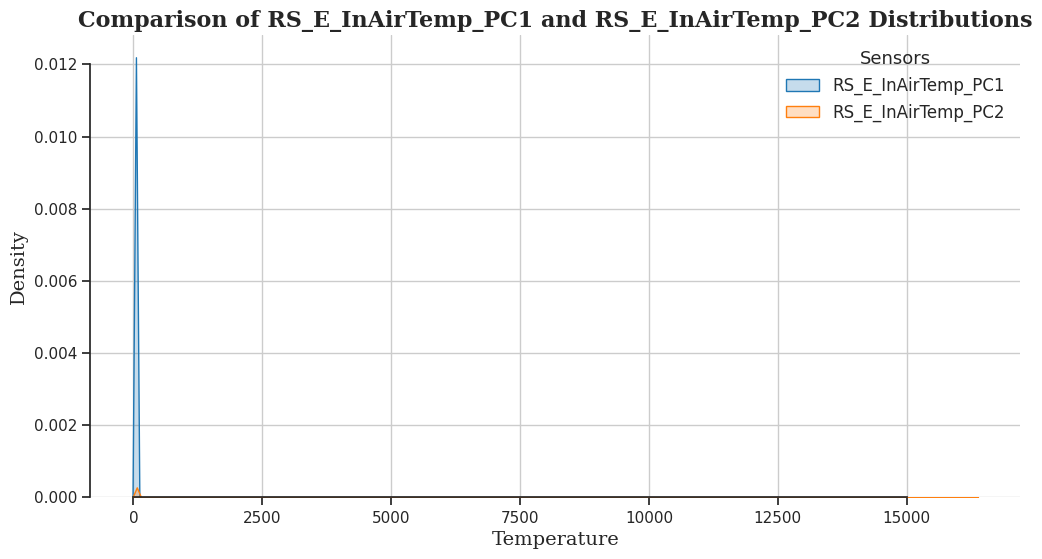

In [22]:
# Setting the overall aesthetics for the plot to have an academic look
sns.set_theme(style='ticks', palette='muted')

# Initialize the matplotlib figure
plt.figure(figsize=(12, 6))

# Plotting the Kernel Density Estimate (KDE) plot for RS_E_InAirTemp_PC1
sns.kdeplot(data['RS_E_InAirTemp_PC1'], fill=True, color="#1f77b4", label='RS_E_InAirTemp_PC1', bw_adjust=0.5)

# Plotting the KDE plot for RS_E_InAirTemp_PC2
sns.kdeplot(data['RS_E_InAirTemp_PC2'], fill=True, color="#ff7f0e", label='RS_E_InAirTemp_PC2', bw_adjust=0.5)

# Adding titles and labels with a formal font type
plt.title('Comparison of RS_E_InAirTemp_PC1 and RS_E_InAirTemp_PC2 Distributions', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Temperature', fontsize=14, family='serif')
plt.ylabel('Density', fontsize=14, family='serif')

# Adding gridlines and removing the top and right axis lines for a cleaner look
sns.despine(trim=True)
plt.grid(True)

# Adjusting the legend to be more formal
plt.legend(title='Sensors', title_fontsize='13', fontsize='12', frameon=False)

# Show the plot with the improved academic aesthetics
plt.show()


the graph seems more reasonable now, but let's check more detailed where is the data larger than 100

In [23]:
data.loc[data['RS_E_InAirTemp_PC1'] > 90]

,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2
1445023,2023-08-18 14:05:30,128.0,50.930459,5.327558,91.0,36.0,10.0,189.0,801.0,799.0,95.0,73.0,92.0,86.0
2513840,2023-04-03 14:24:04,194.0,50.893255,3.810035,122.0,40.0,173.5,286.0,802.5,954.0,51.0,82.0,77.0,82.0
7251976,2023-08-18 14:08:29,128.0,50.930715,5.326633,91.0,36.0,10.0,369.0,796.0,1699.0,93.0,73.0,90.0,85.0
10083194,2023-02-26 06:27:29,152.0,50.095749,4.524782,13131.9,31.7,520.0,589.0,798.0,799.0,18.0,17.0,4.0,6.0
10365770,2023-08-18 14:09:23,128.0,50.932252,5.321323,91.0,37.0,10.0,186.0,798.0,829.0,93.0,76.0,90.0,86.0
10620220,2023-08-18 14:06:33,128.0,50.930469,5.327587,91.0,36.0,10.0,193.0,795.0,797.0,94.0,73.0,90.0,85.0
11377513,2023-08-18 14:08:33,128.0,50.930634,5.326947,91.0,36.0,10.0,369.0,1145.0,1703.0,93.0,73.0,90.0,84.0
13076778,2023-08-18 14:07:28,128.0,50.930630,5.326952,91.0,36.0,10.0,196.0,802.0,800.0,93.0,73.0,90.0,85.0
14442521,2023-08-18 14:07:32,128.0,50.930490,5.327528,91.0,36.0,10.0,189.0,794.0,794.0,94.0,73.0,89.0,84.0
14450719,2023-08-18 14:09:28,128.0,50.932629,5.320049,91.0,37.0,10.0,179.0,799.0,778.0,93.0,76.0,90.0,86.0


In [24]:
data.loc[data['RS_E_InAirTemp_PC2'] > 90]

,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2
324538,2023-06-23 17:01:30,128.0,51.215554,4.420982,42.0,91.0,217.0,3.0,801.0,1134.0,82.0,70.0,82.0,86.0
327681,2023-06-23 16:39:06,128.0,51.139778,4.540462,43.0,92.0,365.5,3.0,1788.5,800.0,90.0,79.0,89.0,92.0
331147,2023-06-23 16:22:02,128.0,51.180817,4.827914,42.0,93.0,196.0,3.0,800.0,808.0,87.0,85.0,85.0,97.0
331253,2023-06-23 16:33:12,128.0,51.151072,4.618712,42.0,93.0,379.0,3.0,1919.0,819.0,85.0,81.0,85.0,93.0
337453,2023-06-23 16:57:07,128.0,51.215085,4.420949,41.0,91.0,210.0,3.0,796.5,796.0,83.0,69.0,84.5,88.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16780040,2023-06-23 16:21:11,128.0,51.180556,4.827335,42.0,93.0,193.0,3.0,797.0,1468.0,88.0,86.0,89.0,97.0
17179772,2023-06-23 16:48:00,128.0,51.194405,4.436466,41.0,92.0,200.0,3.0,802.0,797.0,86.0,73.0,85.0,89.0
17189307,2023-06-23 16:35:12,128.0,51.139300,4.573102,42.0,93.0,203.0,3.0,828.0,798.0,86.0,81.0,87.0,93.0
17195604,2023-06-23 16:24:05,128.0,51.177940,4.820459,42.0,94.0,196.0,3.0,809.0,800.0,88.0,84.0,90.0,96.0


it may be the correct data, there may exist some engineer problems when the temperature is unreasonablely high, so we will figure this out in the next step

but we noticed that there are some temperature -20 in the data which is ubnormal, so let's check what is it

In [25]:
data.loc[data['RS_E_InAirTemp_PC1'] < -5]

,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2
2808943,2023-03-19 10:12:18,162.0,51.013141,3.781080,-17.5,23.0,310.0,3.0,1327.0,1331.0,29.0,22.0,58.0,20.5
4468288,2023-06-15 13:34:23,151.0,51.013158,3.780460,-17.5,28.5,189.0,3.0,811.0,1690.0,-8.5,27.0,16.5,27.5
5184397,2023-06-30 12:33:34,114.0,50.936747,5.305696,-17.0,41.0,196.0,211.5,797.0,808.5,80.0,80.0,76.0,76.0
12233016,2023-06-16 13:19:44,151.0,51.013180,3.781200,-15.5,25.0,6.5,3.0,385.0,1252.5,24.5,23.0,40.0,24.0
12725746,2023-01-29 09:12:21,133.0,50.401060,4.456639,-5.5,-2.5,6.5,320.5,800.0,399.5,77.0,77.0,74.0,73.0
13053345,2023-08-23 09:04:36,168.0,51.013408,3.780621,-17.0,63.0,3.0,10.0,797.0,813.0,43.0,66.0,32.0,66.5
14352660,2023-06-30 12:33:28,114.0,50.936668,5.306341,-17.0,41.0,224.0,186.0,789.0,799.0,80.0,80.0,74.0,76.0


In [26]:
data.loc[data['RS_E_InAirTemp_PC2'] < -5]

,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2
2236133,2023-05-16 23:15:27,161.0,51.013925,3.780516,47.0,-17.5,138.0,3.000000,799.428571,802.250000,76.0,30.000000,73.5,65.500000
2718274,2023-01-24 00:37:18,125.0,50.936568,5.306207,45.0,-17.0,3.0,690.000000,803.000000,663.000000,65.0,-17.000000,50.0,67.000000
3530666,2023-01-30 03:40:02,125.0,51.190165,5.112595,15.0,-17.0,248.0,276.000000,794.000000,801.000000,71.0,-17.000000,66.0,60.000000
3569947,2023-03-15 21:55:34,183.0,51.013405,3.780645,41.0,-17.0,6.0,189.000000,804.000000,812.000000,38.0,-17.000000,38.0,86.000000
5502316,2023-01-29 16:32:02,125.0,51.038318,5.281033,37.0,-17.0,334.0,319.333333,1500.000000,1167.000000,83.0,-17.000000,86.0,85.000000
7059342,2023-01-30 18:41:35,125.0,51.180228,4.826087,35.0,-17.0,203.0,175.000000,830.000000,738.000000,82.0,81.000000,83.0,78.000000
7068414,2023-01-29 08:18:45,125.0,51.119022,5.257582,38.0,-17.0,341.0,378.000000,1498.000000,1284.333333,81.0,-17.000000,86.0,80.666667
7538976,2023-09-03 17:08:51,159.0,50.792241,3.866546,46.0,-17.0,169.0,242.800000,800.000000,801.000000,91.0,-17.000000,89.0,85.400000
7785627,2023-07-09 18:05:46,137.0,51.190644,5.113072,26.0,-17.0,518.5,210.000000,798.000000,840.000000,36.5,-17.000000,30.5,91.000000
8810344,2023-03-15 21:51:57,183.0,51.013422,3.780588,42.0,-15.5,6.0,6.500000,810.285714,401.000000,38.0,89.285714,38.0,45.000000


those data are rare and uncontinues, so just delete them is fine

In [27]:
# Remove the row with the specific erroneous value mentioned in the analysis
data = data[data['RS_E_InAirTemp_PC1'] >-6]
data = data[data['RS_E_InAirTemp_PC2'] >-6]

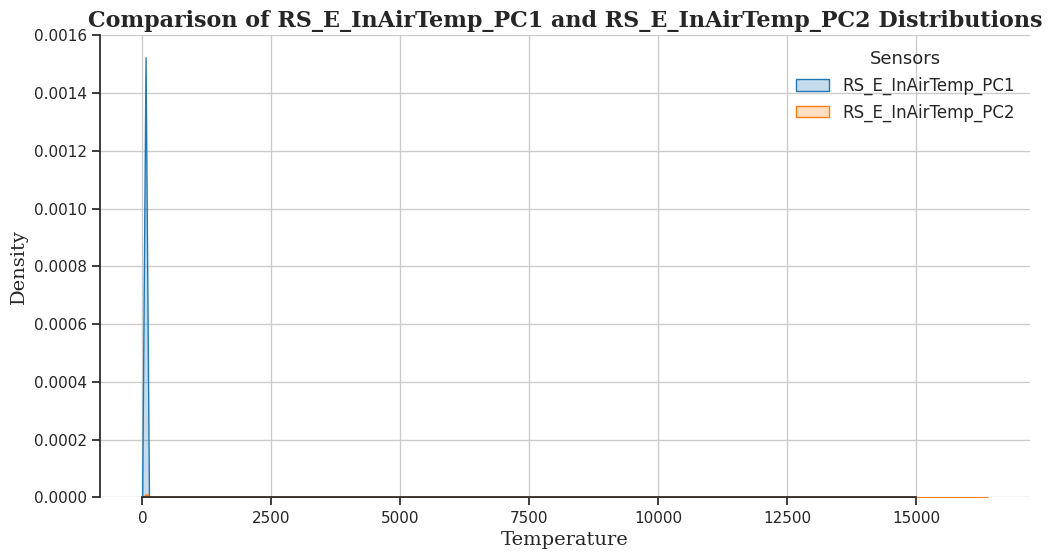

In [28]:
# Setting the overall aesthetics for the plot to have an academic look
sns.set_theme(style='ticks', palette='muted')

# Initialize the matplotlib figure
plt.figure(figsize=(12, 6))

# Plotting the Kernel Density Estimate (KDE) plot for RS_E_InAirTemp_PC1
sns.kdeplot(data['RS_E_InAirTemp_PC1'], fill=True, color="#1f77b4", label='RS_E_InAirTemp_PC1', bw_adjust=0.5)

# Plotting the KDE plot for RS_E_InAirTemp_PC2
sns.kdeplot(data['RS_E_InAirTemp_PC2'], fill=True, color="#ff7f0e", label='RS_E_InAirTemp_PC2', bw_adjust=0.5)

# Adding titles and labels with a formal font type
plt.title('Comparison of RS_E_InAirTemp_PC1 and RS_E_InAirTemp_PC2 Distributions', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Temperature', fontsize=14, family='serif')
plt.ylabel('Density', fontsize=14, family='serif')

# Adding gridlines and removing the top and right axis lines for a cleaner look
sns.despine(trim=True)
plt.grid(True)

# Adjusting the legend to be more formal
plt.legend(title='Sensors', title_fontsize='13', fontsize='12', frameon=False)

# Show the plot with the improved academic aesthetics
plt.show()


# Distribution of RS_E_OilPress_PC1 and RS_E_OilPress_PC2

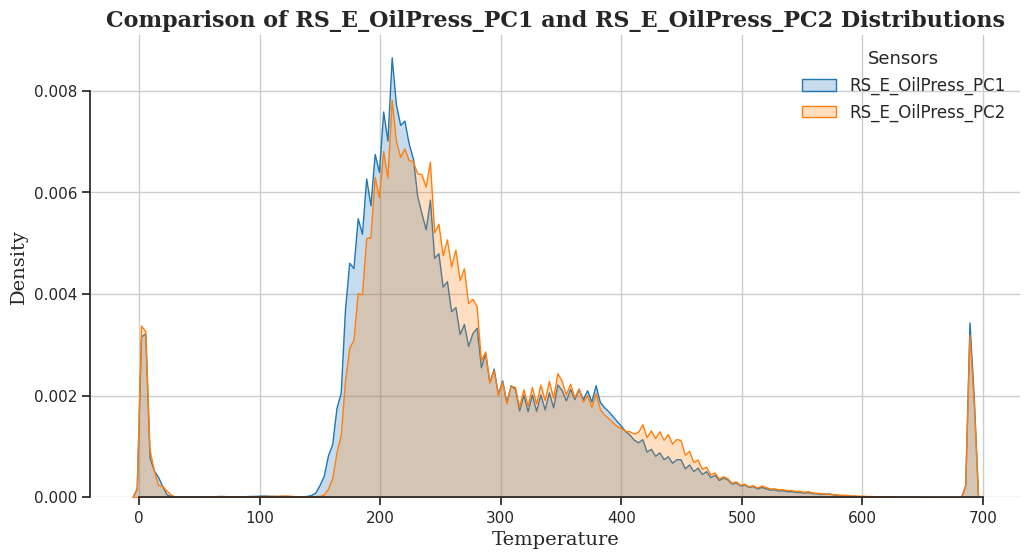

In [29]:
# Setting the overall aesthetics for the plot to have an academic look
sns.set_theme(style='ticks', palette='muted')

# Initialize the matplotlib figure
plt.figure(figsize=(12, 6))

# Plotting the Kernel Density Estimate (KDE) plot for RS_E_OilPress_PC1
sns.kdeplot(data['RS_E_OilPress_PC1'], fill=True, color="#1f77b4", label='RS_E_OilPress_PC1', bw_adjust=0.5)

# Plotting the KDE plot for RS_E_OilPress_PC2
sns.kdeplot(data['RS_E_OilPress_PC2'], fill=True, color="#ff7f0e", label='RS_E_OilPress_PC2', bw_adjust=0.5)

# Adding titles and labels with a formal font type
plt.title('Comparison of RS_E_OilPress_PC1 and RS_E_OilPress_PC2 Distributions', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Temperature', fontsize=14, family='serif')
plt.ylabel('Density', fontsize=14, family='serif')

# Adding gridlines and removing the top and right axis lines for a cleaner look
sns.despine(trim=True)
plt.grid(True)

# Adjusting the legend to be more formal
plt.legend(title='Sensors', title_fontsize='13', fontsize='12', frameon=False)

# Show the plot with the improved academic aesthetics
plt.show()


# Distribution of RS_E_RPM_PC1 and RS_E_RPM_PC2 

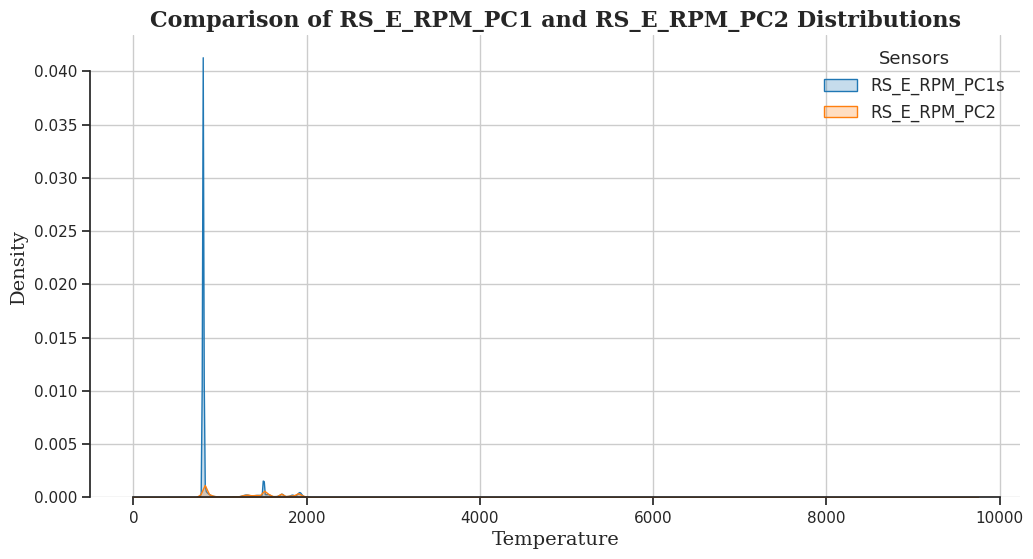

In [30]:
# Setting the overall aesthetics for the plot to have an academic look
sns.set_theme(style='ticks', palette='muted')

# Initialize the matplotlib figure
plt.figure(figsize=(12, 6))

# Plotting the Kernel Density Estimate (KDE) plot for RS_E_RPM_PC1
sns.kdeplot(data['RS_E_RPM_PC1'], fill=True, color="#1f77b4", label='RS_E_RPM_PC1s', bw_adjust=0.5)

# Plotting the KDE plot for RS_E_RPM_PC2
sns.kdeplot(data['RS_E_RPM_PC2'], fill=True, color="#ff7f0e", label='RS_E_RPM_PC2', bw_adjust=0.5)

# Adding titles and labels with a formal font type
plt.title('Comparison of RS_E_RPM_PC1 and RS_E_RPM_PC2 Distributions', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Temperature', fontsize=14, family='serif')
plt.ylabel('Density', fontsize=14, family='serif')

# Adding gridlines and removing the top and right axis lines for a cleaner look
sns.despine(trim=True)
plt.grid(True)

# Adjusting the legend to be more formal
plt.legend(title='Sensors', title_fontsize='13', fontsize='12', frameon=False)

# Show the plot with the improved academic aesthetics
plt.show()


In [31]:
data[data['RS_E_RPM_PC1'] > 3000]

,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2


In [32]:
data[data['RS_E_RPM_PC2'] > 3000]

,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2
55165,2023-08-17 15:40:29,164.0,51.033765,5.329525,31.0,38.0,396.0,207.0,1389.0,9732.0,83.0,78.0,82.0,84.0
3642546,2023-02-06 10:35:17,140.0,50.393047,4.382487,12.0,20.0,17.0,189.5,796.0,6790.5,11.0,84.5,16.5,87.0


the high RPM is not continus and the data is unreasonable, so it is safe to remove those two errors data

In [33]:
data = data[data['RS_E_RPM_PC2'] < 3000]

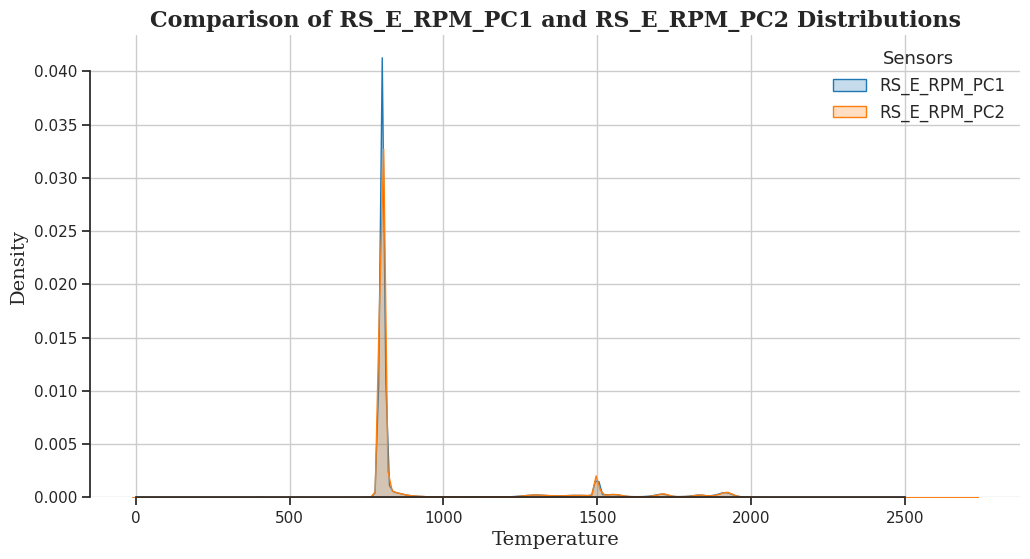

In [34]:
# Setting the overall aesthetics for the plot to have an academic look
sns.set_theme(style='ticks', palette='muted')

# Initialize the matplotlib figure
plt.figure(figsize=(12, 6))

# Plotting the Kernel Density Estimate (KDE) plot for RS_E_RPM_PC1
sns.kdeplot(data['RS_E_RPM_PC1'], fill=True, color="#1f77b4", label='RS_E_RPM_PC1', bw_adjust=0.5)

# Plotting the KDE plot for RS_E_RPM_PC2
sns.kdeplot(data['RS_E_RPM_PC2'], fill=True, color="#ff7f0e", label='RS_E_RPM_PC2', bw_adjust=0.5)

# Adding titles and labels with a formal font type
plt.title('Comparison of RS_E_RPM_PC1 and RS_E_RPM_PC2 Distributions', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Temperature', fontsize=14, family='serif')
plt.ylabel('Density', fontsize=14, family='serif')

# Adding gridlines and removing the top and right axis lines for a cleaner look
sns.despine(trim=True)
plt.grid(True)

# Adjusting the legend to be more formal
plt.legend(title='Sensors', title_fontsize='13', fontsize='12', frameon=False)

# Show the plot with the improved academic aesthetics
plt.show()

the graph becomes more reasonable

# Distribution of RS_E_WatTemp_PC1 and RS_E_WatTemp_PC2

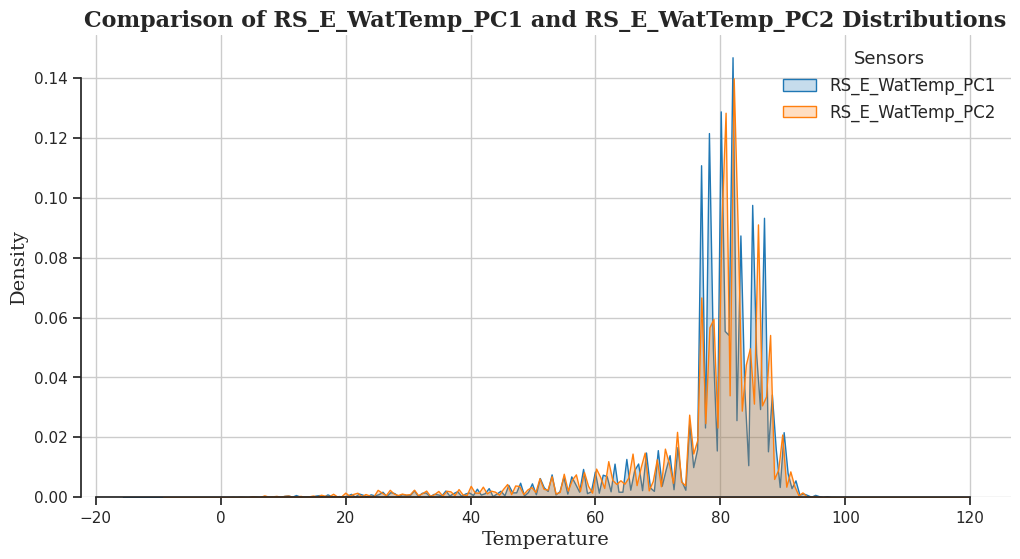

In [35]:
# Setting the overall aesthetics for the plot to have an academic look
sns.set_theme(style='ticks', palette='muted')

# Initialize the matplotlib figure
plt.figure(figsize=(12, 6))

# Plotting the Kernel Density Estimate (KDE) plot for RS_E_WatTemp_PC1
sns.kdeplot(data['RS_E_WatTemp_PC1'], fill=True, color="#1f77b4", label='RS_E_WatTemp_PC1', bw_adjust=0.5)

# Plotting the KDE plot for RS_E_WatTemp_PC2
sns.kdeplot(data['RS_E_WatTemp_PC2'], fill=True, color="#ff7f0e", label='RS_E_WatTemp_PC2', bw_adjust=0.5)

# Adding titles and labels with a formal font type
plt.title('Comparison of RS_E_WatTemp_PC1 and RS_E_WatTemp_PC2 Distributions', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Temperature', fontsize=14, family='serif')
plt.ylabel('Density', fontsize=14, family='serif')

# Adding gridlines and removing the top and right axis lines for a cleaner look
sns.despine(trim=True)
plt.grid(True)

# Adjusting the legend to be more formal
plt.legend(title='Sensors', title_fontsize='13', fontsize='12', frameon=False)

# Show the plot with the improved academic aesthetics
plt.show()

# Distribution of RS_T_OilTemp_PC1 and RS_T_OilTemp_PC2

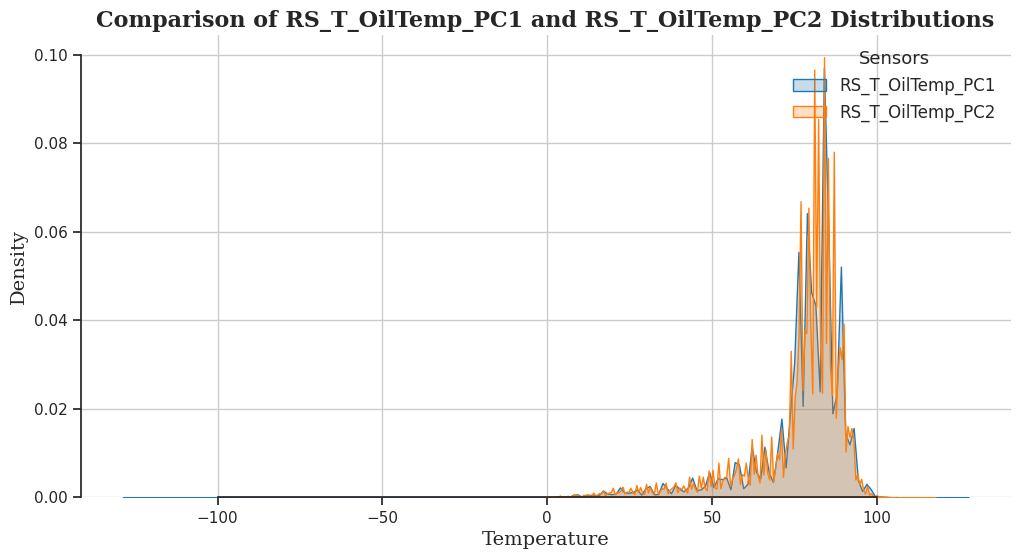

In [36]:
# Setting the overall aesthetics for the plot to have an academic look
sns.set_theme(style='ticks', palette='muted')

# Initialize the matplotlib figure
plt.figure(figsize=(12, 6))

# Plotting the Kernel Density Estimate (KDE) plot for RS_T_OilTemp_PC1
sns.kdeplot(data['RS_T_OilTemp_PC1'], fill=True, color="#1f77b4", label='RS_T_OilTemp_PC1', bw_adjust=0.5)

# Plotting the KDE plot for RS_T_OilTemp_PC2
sns.kdeplot(data['RS_T_OilTemp_PC2'], fill=True, color="#ff7f0e", label='RS_T_OilTemp_PC2', bw_adjust=0.5)

# Adding titles and labels with a formal font type
plt.title('Comparison of RS_T_OilTemp_PC1 and RS_T_OilTemp_PC2 Distributions', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Temperature', fontsize=14, family='serif')
plt.ylabel('Density', fontsize=14, family='serif')

# Adding gridlines and removing the top and right axis lines for a cleaner look
sns.despine(trim=True)
plt.grid(True)

# Adjusting the legend to be more formal
plt.legend(title='Sensors', title_fontsize='13', fontsize='12', frameon=False)

# Show the plot with the improved academic aesthetics
plt.show()

# Distribution of lon and lat

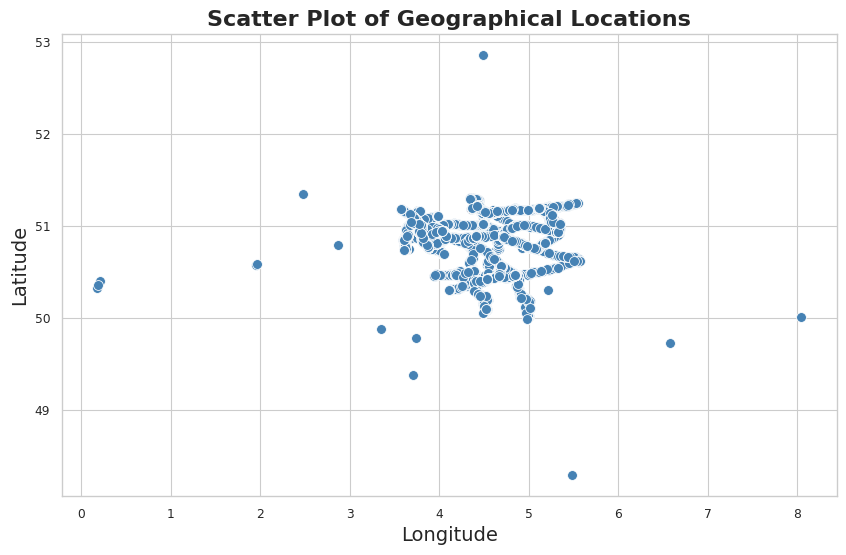

In [37]:
# Set the style of the visualization
sns.set_style("whitegrid")
sns.set_context("paper")

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='lon', y='lat', data=data, color='steelblue', s=50)  # s is the size of the markers

# Set title and labels with academic formatting
plt.title('Scatter Plot of Geographical Locations', fontsize=16, weight='bold')
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)

# Show the plot
plt.show()

it seems there exists some outliers in lon and lat, let's try to remove it

In [38]:
# Make use of IQR Methodology
Q1 = data['lat'].quantile(0.25)
Q3 = data['lat'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define Outlier Boundary
lower_bound = Q1 - 2.5 * IQR
upper_bound = Q3 + 2 * IQR

# Define Outliers
outliers = data[(data['lat'] < lower_bound) | (data['lat'] > upper_bound)]

outliers['lat']

377873      49.383591
1239993     49.780084
2929855     52.857059
8953244     48.295677
9355621     49.881053
14485639    49.729545
Name: lat, dtype: float64

In [39]:
# Filtering out the outliers directly without using the .drop() method
data = data[~((data['lat'] < lower_bound) | (data['lat'] > upper_bound))]
data.shape

(17679231, 14)

In [40]:
# Make use of IQR Methodology
Q1 = data['lon'].quantile(0.25)
Q3 = data['lon'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define Outlier Boundary
lower_bound = Q1 - 1 * IQR
upper_bound = Q3 + 1.5 * IQR

# Define Outliers
outliers = data[(data['lon'] < lower_bound) | (data['lon'] > upper_bound)]

outliers['lon']

3213259     0.206793
4484586     0.175049
8972089     8.045492
9624290     2.474403
12241898    1.954037
13246459    0.190611
16414114    2.872149
17612420    1.960787
Name: lon, dtype: float64

In [41]:
# Filtering out the outliers directly without using the .drop() method
data = data[~((data['lon'] < lower_bound) | (data['lon'] > upper_bound))]
data.shape

(17679223, 14)

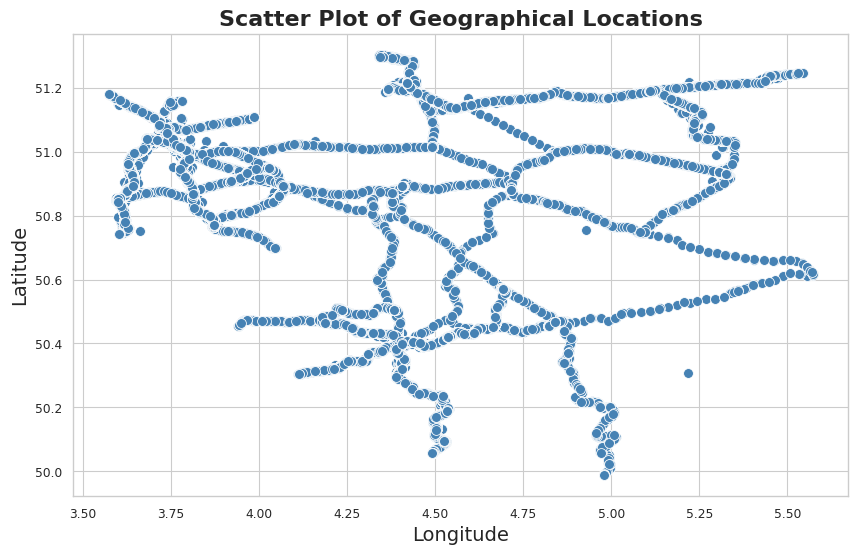

In [42]:
# Set the style of the visualization
sns.set_style("whitegrid")
sns.set_context("paper")

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='lon', y='lat', data=data, color='steelblue', s=50)  # s is the size of the markers

# Set title and labels with academic formatting
plt.title('Scatter Plot of Geographical Locations', fontsize=16, weight='bold')
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)

# Show the plot
plt.show()

# Distribution of timestamps_UTC

Convert the 'timestamps_UTC' column to datetime

In [43]:
# Convert 'timestamps_UTC' to datetime only once, and drop it immediately after extraction
data['timestamps_UTC'] = pd.to_datetime(data['timestamps_UTC'])  # Removed errors='coerce' for optimization
data['date'] = data['timestamps_UTC'].dt.date
data['hour'] = data['timestamps_UTC'].dt.hour
data['dayofweek'] = data['timestamps_UTC'].dt.dayofweek
data['weekday'] = data['timestamps_UTC'].dt.strftime('%A')

# Call the garbage collector to free up memory
gc.collect()

29042

let's detect is there any outliers in date data

In [44]:
# Set the option to display up to 50 rows to shows all the results
pd.set_option('display.max_rows', 50)

date_distribution = data['date'].value_counts().sort_index()
date_distribution

date
2022-08-22        22
2022-10-14         2
2022-11-08         3
2022-11-21         6
2022-12-19         1
               ...  
2023-09-09     33061
2023-09-10     34621
2023-09-11     99016
2023-09-12    102525
2023-09-13     96949
Name: count, Length: 259, dtype: int64

In [45]:
# Set the option to display up to 50 rows to shows all the results
pd.set_option('display.max_rows', 50)
data[data['date'] == pd.to_datetime('2023-01-05').date()]

,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2,date,hour,dayofweek,weekday
387835,2023-01-05 04:08:17,114.0,51.167832,4.970915,16.0,37.0,365.0,369.0,1488.0,1504.0,81.0,81.0,77.0,81.0,2023-01-05,4,3,Thursday
387860,2023-01-05 09:38:28,114.0,51.224405,4.440917,15.0,21.0,244.0,241.0,797.0,819.0,80.0,80.0,73.0,74.0,2023-01-05,9,3,Thursday
388129,2023-01-05 06:59:46,114.0,51.291419,4.399841,13.0,30.0,217.0,210.0,791.0,794.0,79.0,79.0,76.0,78.0,2023-01-05,6,3,Thursday
388130,2023-01-05 04:06:25,114.0,51.169224,4.990896,15.0,36.0,224.0,213.0,799.0,790.0,78.0,78.0,76.0,78.0,2023-01-05,4,3,Thursday
388131,2023-01-05 03:51:36,114.0,51.190393,5.113896,13.0,21.0,231.0,227.0,795.0,802.0,80.0,80.0,74.0,75.0,2023-01-05,3,3,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16694651,2023-01-05 03:23:40,114.0,51.190395,5.113913,13.0,20.0,244.0,244.0,801.0,802.0,77.0,78.0,70.0,71.0,2023-01-05,3,3,Thursday
17386068,2023-01-05 03:52:57,114.0,51.190425,5.113904,13.0,21.0,231.0,224.0,797.0,794.0,80.0,80.0,75.0,75.0,2023-01-05,3,3,Thursday
17398823,2023-01-05 03:25:28,114.0,51.190412,5.113923,13.0,20.0,244.0,238.0,802.0,798.0,78.0,78.0,70.0,71.0,2023-01-05,3,3,Thursday
17407804,2023-01-05 20:38:39,114.0,51.221958,5.437313,19.0,26.0,231.0,220.0,800.0,801.0,79.0,78.0,76.0,77.0,2023-01-05,20,3,Thursday


we can find that the data is uncontinues and almost useless, so let's remove the data of date frequency less than 1000

In [46]:
# Find dates with a frequency of less than 1000
dates_to_remove = date_distribution[date_distribution < 1000].index

# Remove these dates from the DataFrame
data = data[~data['date'].isin(dates_to_remove)]

data.shape

(17677334, 18)

Draw the distribution of date

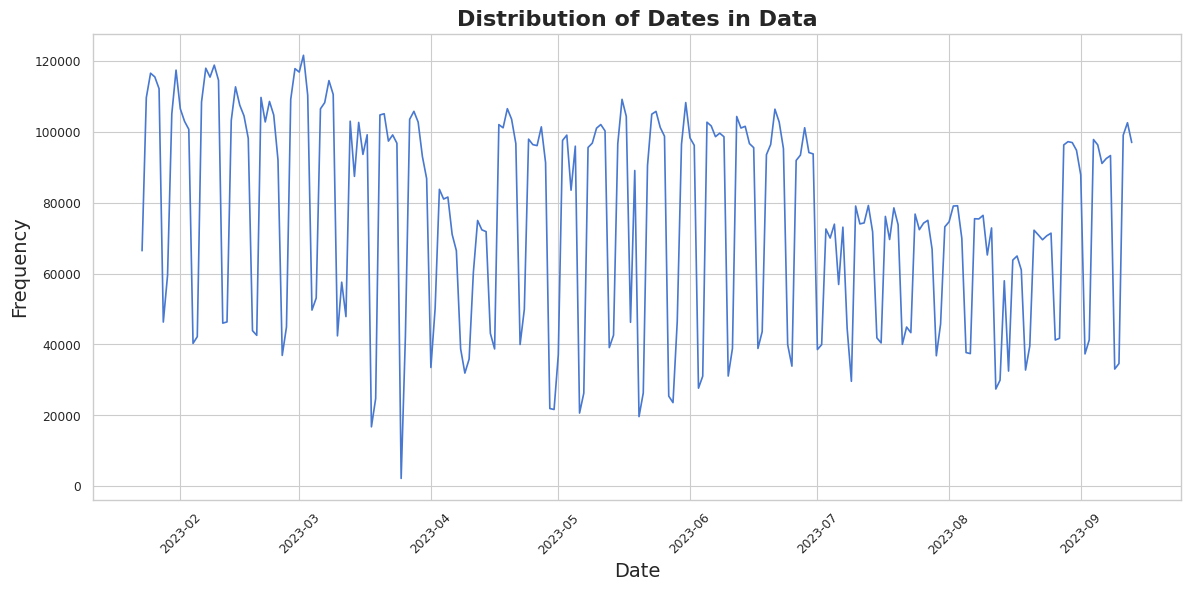

In [47]:
# Convert 'date' to datetime if it's not already
data['date'] = pd.to_datetime(data['date'])

# Count the occurrences of each date
date_counts = data['date'].value_counts().sort_index()

# Set the style of the visualization
sns.set_style("whitegrid")
sns.set_context("paper")

# Initialize the matplotlib figure
plt.figure(figsize=(12, 6))

# Plot the distribution of dates
# Using a line plot if you want to see trends over time
sns.lineplot(x=date_counts.index, y=date_counts.values)

# Or using a bar plot if you want to see frequency distribution
# sns.barplot(x=date_counts.index, y=date_counts.values)

# Set title and labels with academic formatting
plt.title('Distribution of Dates in Data', fontsize=16, weight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Rotate date labels to avoid overlap
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

Count the occurrences of each hour and weekday

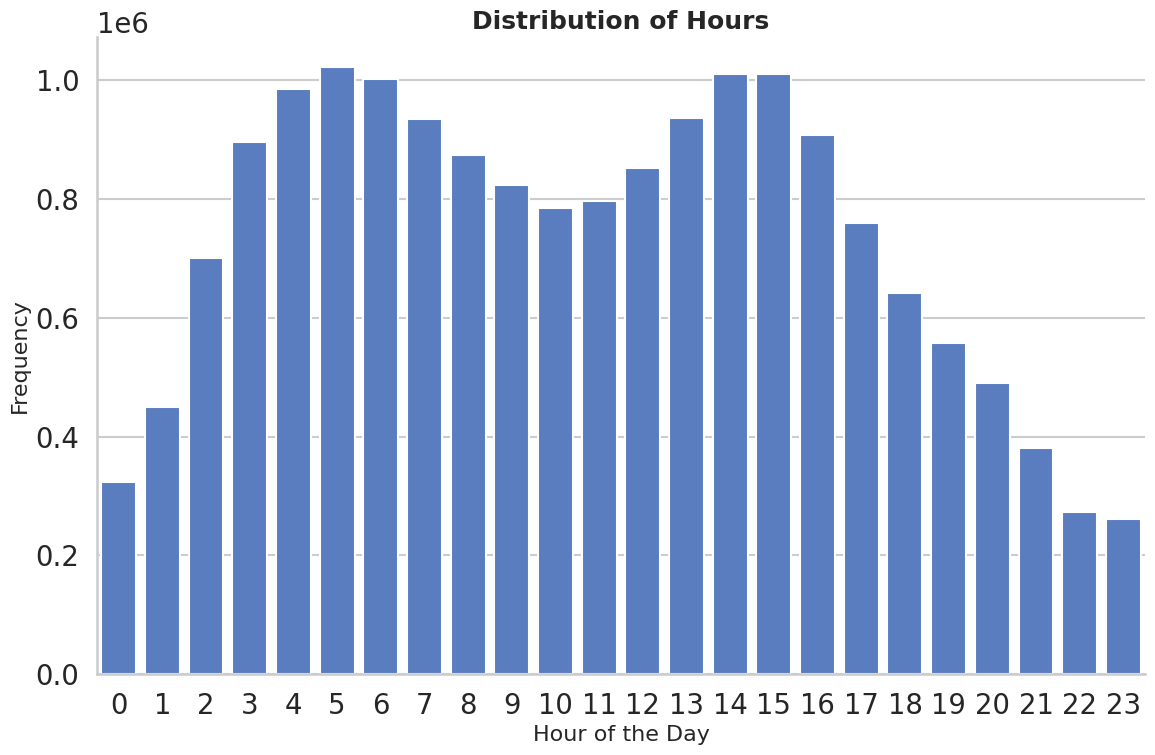

In [48]:
# Calculate the frequency of each hour
hour_counts = data['hour'].value_counts().sort_index()

# Set the style of the visualization
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.2)

# Initialize the matplotlib figure
plt.figure(figsize=(12, 8))

# Create the bar plot using the default Seaborn blue color
ax = sns.barplot(x=hour_counts.index, y=hour_counts.values, color="C0")

# Set title and labels with academic formatting
plt.title('Distribution of Hours', fontsize=18, weight='bold')
plt.xlabel('Hour of the Day', fontsize=16)
plt.ylabel('Frequency', fontsize=16)  # Use 'Frequency' instead of 'Percentage'

# Remove the top and right spines for a cleaner look
sns.despine()

# Show the plot
plt.tight_layout()
plt.show()

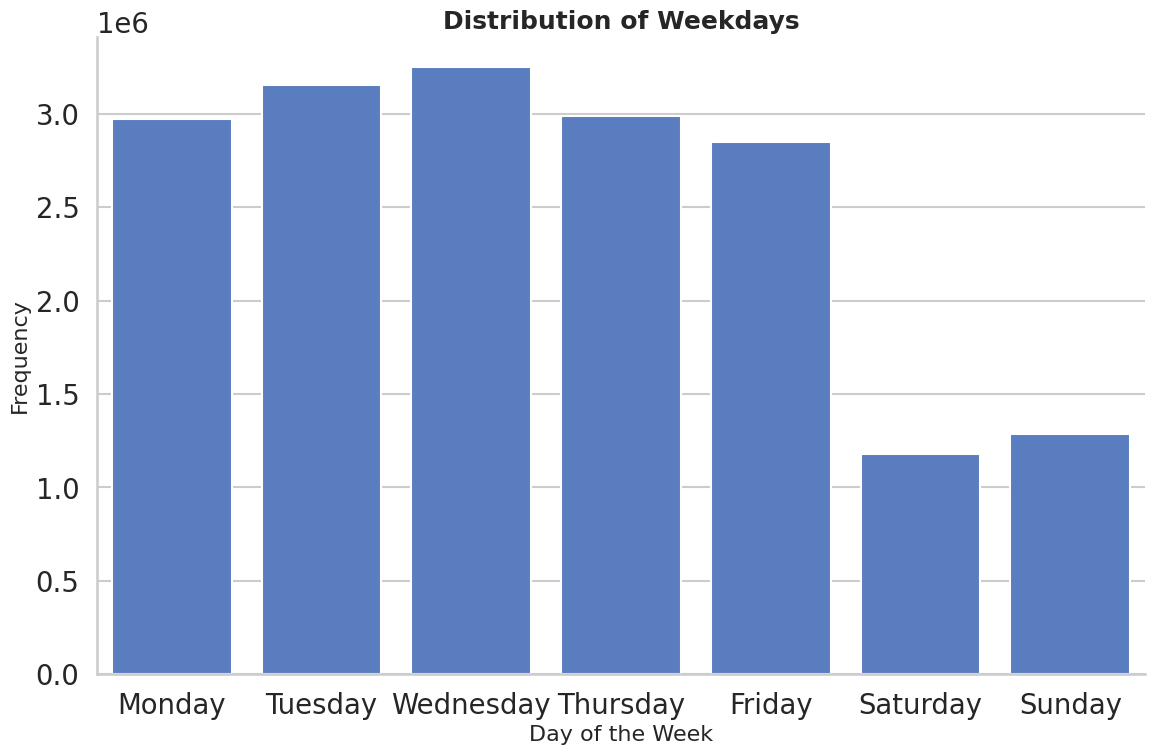

In [49]:
days_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 
            4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
# data['dayofweek'] = data['dayofweek'].map(days_map)  # Adjust this line as needed

# Calculate the frequency of each day of the week
weekday_counts = data['dayofweek'].map(days_map).value_counts().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

# Plotting the distribution of weekdays
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=weekday_counts.index, y=weekday_counts.values, color="C0")
plt.title('Distribution of Weekdays', fontsize=18, weight='bold')
plt.xlabel('Day of the Week', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
sns.despine()
plt.tight_layout()
plt.show()

# Diagnose the Missing Value

showing the data with data['mapped_veh_id'] == 102.0 and data == "2023-02-27" to diagnose the Missing Value

In [50]:
# change pd settings to show 70 rows
pd.set_option('display.max_rows', 70)

# using the training id == 102
data_1 = data[(data['mapped_veh_id'] == 102.0)]

data_1.sort_values('date', inplace=True)

# choosing date == 2023-02-27
# result = data_1[data_1['date'] == pd.to_datetime("2023-02-27").date()]
data_1[data_1['date'] == pd.to_datetime("2023-02-27").date()]
# print(result)

/tmp/ipykernel_20/4193090755.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1.sort_values('date', inplace=True)


,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2,date,hour,dayofweek,weekday


we can choose an iconic part of interesting data:

| mapped_veh_id | timestamps_UTC | lat       | lon      | RS_E_InAirTemp_PC1 | RS_E_InAirTemp_PC2 | RS_E_OilPress_PC1 | RS_E_OilPress_PC2 | RS_E_RPM_PC1 | RS_E_RPM_PC2 | RS_E_WatTemp_PC1 | RS_E_WatTemp_PC2 | RS_T_OilTemp_PC1 | RS_T_OilTemp_PC2 | date       | time     |
|---------------|----------------|-----------|----------|--------------------|--------------------|-------------------|-------------------|--------------|--------------|------------------|------------------|------------------|------------------|------------|---------|
| 1212149       | 102.0          | 51.014305 | 3.777572 | 5.0                | 1.0                | 486.0             | 465.0             | 798.00       | 802.00       | 40.0              | 44.0              | 28.0              | 34.00             | 2023-02-27 | 05:51:49 |
| 8948897       | 102.0          | 51.013711 | 3.779479 | 5.0                | 1.0                | 483.0             | 465.0             | 797.00       | 800.00       | 41.0              | 45.0              | 28.0              | 35.00             | 2023-02-27 | 05:52:20 |
| 8906016       | 102.0          | 51.013922 | 3.779001 | 0.0                | 1.0                | 0.0               | 131.0             | 0.00         | 0.00         | 0.0               | 45.0              | 26.0              | 34.00             | 2023-02-27 | 05:52:29 |
| 11817588      | 102.0          | 51.013670 | 3.779544 | 0.0                | 1.0                | 120.0             | 148.0             | 0.00         | 211.00       | 0.0               | 45.0              | 26.0              | 35.00             | 2023-02-27 | 05:52:30 |
| 6107927       | 102.0          | 51.013928 | 3.779015 | 0.0                | 0.0                | 0.0               | 0.0               | 0.00         | 0.00         | 0.0               | 0.0               | 24.0              | 34.00             | 2023-02-27 | 05:52:50 |
| 14922602      | 102.0          | 51.013925 | 3.779021 | 0.0                | 0.0                | 0.0               | 0.0               | 0.00         | 0.00         | 40.0              | 0.0               | 28.0              | 35.00             | 2023-02-27 | 05:52:59 |
| 8923184       | 102.0          | 51.013689 | 3.779530 | 7.0                | 3.0                | 0.0               | 0.0               | 0.00         | 0.00         | 40.0              | 0.0               | 25.0              | 34.00             | 2023-02-27 | 05:53:00 |
| 3628039       | 102.0          | 51.013924 | 3.779001 | 8.0                | NaN                | 0.0               | NaN               | 0.00         | NaN          | 40.0              | NaN               | 25.0              | NaN              | 2023-02-27 | 05:53:19 |
| 4831678       | 102.0          | 51.013933 | 3.779009 | 0.0                | NaN                | 0.0               | NaN               | 0.00         | NaN          | 0.0               | NaN               | 25.0              | NaN              | 2023-02-27 | 05:53:29 |
| 10987874      | 102.0          | 51.013939 | 3.779012 | 0.0                | NaN                | 0.0               | NaN               | 0.00         | NaN          | 0.0               | NaN               | 27.0              | NaN              | 2023-02-27 | 05:53:49 |


we can find that the 0 and NaN is also coming together, we assume that the senser should have some bugs at this time

Find a lot of missing values, and the count of them are the same, so let's try to diagnose whether it is caused by systematic problem of senser from PC2

In [51]:
# change pd settings to show 50 rows
pd.set_option('display.max_rows', 50)

data[data.isna().any(axis=1)].sort_values('date')

,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2,date,hour,dayofweek,weekday


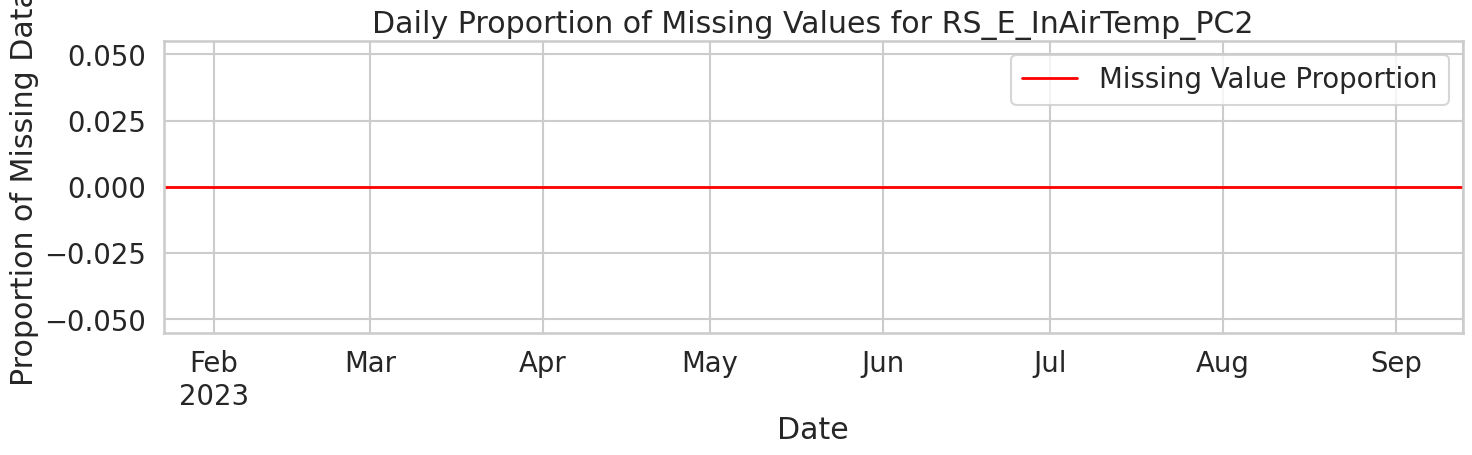

In [52]:
# Make sure 'date' is in datetime format
data['date'] = pd.to_datetime(data['date'])

# Group by 'date' and calculate the mean of null values for 'RS_E_InAirTemp_PC2'
daily_missing_data = data.groupby(pd.Grouper(key='date', freq='D'))['RS_E_InAirTemp_PC2'].apply(lambda x: x.isnull().mean())

# Plotting the line plot
plt.figure(figsize=(15, 5))
daily_missing_data.plot(kind='line', color='red', label='Missing Value Proportion', lw=2)
plt.xlabel('Date')
plt.ylabel('Proportion of Missing Data')
plt.title('Daily Proportion of Missing Values for RS_E_InAirTemp_PC2')
plt.legend()
plt.grid(True)  # Adding grid for better readability
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

Because the time series data missing part is uncontinues and propotion is pretty low, which is lower than 1% every day, so we can fill those NaN values with previous data

In [53]:
# Fill NaN with previous data
data.fillna(method='ffill', inplace=True)

# Check is any NaN value exists
data[data.isna().any(axis=1)]

,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2,date,hour,dayofweek,weekday


# Remove Duplicate Rows

In [54]:
print(data.shape)

(17677334, 18)


In [55]:
data.drop_duplicates(inplace=True)

In [56]:
print(data.shape)

(17677334, 18)


no duplicate was found, move on

# Remove Value 0 from all columns

this code not worked because it will remove the tempure higher than usual (the information we need), bue do not treat tempurature 0 as outlier

In [57]:
# # Make use of IQR Methodology
# Q1 = data['RS_E_InAirTemp_PC1'].quantile(0.25)
# Q3 = data['RS_E_InAirTemp_PC1'].quantile(0.75)

# # Calculate IQR
# IQR = Q3 - Q1

# # Define Outlier Boundary
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Define Outliers
# outliers = data[(data['RS_E_InAirTemp_PC1'] < lower_bound) | (data['RS_E_InAirTemp_PC1'] > upper_bound)]

# outliers['RS_E_InAirTemp_PC1']

In [58]:
# list of columns should not contain 0 value
columns_need_check = ['mapped_veh_id', 'date', 'lat', 'lon', 'RS_E_InAirTemp_PC1', 'RS_E_InAirTemp_PC2', 'RS_E_OilPress_PC1',
       'RS_E_OilPress_PC2', 'RS_E_RPM_PC1', 'RS_E_RPM_PC2', 'RS_E_WatTemp_PC1', 'RS_E_WatTemp_PC2', 'RS_T_OilTemp_PC1', 'RS_T_OilTemp_PC2']

# Remove all the rows where columns value contains 0
data = data[(data[columns_need_check] != 0).all(axis=1)]

data.shape

(17677334, 18)

# Group the data by column mapped_veh_id

In [59]:
data['mapped_veh_id']

0           181.0
1           143.0
2           183.0
3           177.0
4           143.0
            ...  
17679268    180.0
17679269    180.0
17679270    122.0
17679271    177.0
17679272    110.0
Name: mapped_veh_id, Length: 17677334, dtype: float64

In [60]:
data.sort_values(by=['mapped_veh_id', 'timestamps_UTC'], inplace=True)
data

,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2,date,hour,dayofweek,weekday
5493376,2023-01-23 07:25:08,102.0,51.017864,3.769079,17.0,18.0,210.0,210.0,858.0,839.0,78.0,80.0,71.0,79.0,2023-01-23,7,0,Monday
8969009,2023-01-23 07:25:16,102.0,51.017875,3.769046,17.0,20.0,200.0,200.0,801.0,804.0,79.0,80.0,76.0,79.0,2023-01-23,7,0,Monday
13873566,2023-01-23 07:25:37,102.0,51.017208,3.770179,19.0,20.0,193.0,207.0,803.0,808.0,80.0,81.0,79.0,81.0,2023-01-23,7,0,Monday
14994675,2023-01-23 07:25:41,102.0,51.016916,3.771036,19.0,20.0,196.0,203.0,801.0,803.0,80.0,81.0,79.0,81.0,2023-01-23,7,0,Monday
11935795,2023-01-23 07:26:10,102.0,51.016503,3.772182,19.0,21.0,200.0,203.0,795.0,807.0,80.0,82.0,79.0,79.0,2023-01-23,7,0,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1820536,2023-09-13 17:33:03,197.0,50.402693,4.450111,37.0,40.0,220.0,258.0,803.0,803.0,81.0,79.0,77.0,81.0,2023-09-13,17,2,Wednesday
17128255,2023-09-13 17:33:58,197.0,50.401657,4.452693,37.0,38.0,224.0,307.0,843.0,941.0,80.0,78.0,77.0,80.0,2023-09-13,17,2,Wednesday
15456252,2023-09-13 17:34:03,197.0,50.401830,4.452217,37.0,38.0,224.0,307.0,841.0,932.0,80.0,78.0,77.0,80.0,2023-09-13,17,2,Wednesday
7666957,2023-09-13 17:34:58,197.0,50.401057,4.455388,36.0,38.0,207.0,244.0,800.0,803.0,81.0,80.0,77.0,82.0,2023-09-13,17,2,Wednesday


In [61]:
# Set 'timestamps_UTC' as the index
data.set_index('timestamps_UTC', inplace=True)

# Save Cleaned Data as a new Dataset

In [62]:
data.to_csv('cleaned_ar41_for_ulb.csv', index=True)